Download the data

In [0]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2019-07-25 20:44:02--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.166.83, 13.225.166.79, 13.225.166.120, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.166.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.01s   

2019-07-25 20:44:02 (194 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/It

In [0]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [0]:
from __future__ import unicode_literals, print_function, division
from google.colab import drive
from io import open
import glob
import os
import random

os.chdir('/content/drive/My Drive/Colab Notebooks/')

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8*len(lines)))]
    test_data[category] = lines[int(math.floor(0.8*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/French.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Korean.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Russian.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [0]:
print(category_lines['Italian'][:5])

['Battaglia', 'Benetton', 'Vestri', 'Filippi', 'Agani']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [0]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [0]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [0]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [0]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9114, -2.9319, -2.9313, -2.9246, -2.9609, -2.9266, -2.8473, -2.9052,
         -2.9015, -2.9138, -2.8635, -2.8953, -2.9430, -2.7950, -2.8822, -2.8326,
         -2.8252, -2.8533]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 13)


We will also want a quick way to get a training example (a name and its
language):




In [0]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Lawniczak
category = Spanish / line = Etxebarria
category = Scottish / line = Miller
category = Portuguese / line = Ferro
category = Vietnamese / line = Chu
category = Korean / line = Sin
category = Irish / line = Cearbhall
category = German / line = Acker
category = Russian / line = Kalinchenko
category = Chinese / line = See 


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [0]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [0]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [0]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []
  
  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses.append(test_loss.item() / n_test_instances)

linear_losses = all_test_losses

5000 5% (0m 13s) 1.5501 Mei / Chinese ✓
10000 10% (0m 29s) 2.4105 Grygarova / Spanish ✗ (Czech)
15000 15% (0m 45s) 0.7498 Fei / Chinese ✓
20000 20% (1m 1s) 2.4540 Geyer / German ✗ (English)
25000 25% (1m 17s) 2.0439 Nam / Vietnamese ✗ (Korean)
30000 30% (1m 33s) 0.7266 Madeira / Portuguese ✓
35000 35% (1m 48s) 0.0558 Filipowski / Polish ✓
40000 40% (2m 4s) 5.7429 Jarzembowski / Polish ✗ (Czech)
45000 45% (2m 20s) 1.3018 Venn / Dutch ✓
50000 50% (2m 36s) 0.3410 Jong / Korean ✓
55000 55% (2m 52s) 1.5268 Mayer / German ✓
60000 60% (3m 7s) 0.0316 Strilakos / Greek ✓
65000 65% (3m 23s) 1.7989 Oquendo / Irish ✗ (Spanish)
70000 70% (3m 39s) 1.1446 Savchak / Polish ✗ (Czech)
75000 75% (3m 55s) 0.8093 Cha / Korean ✓
80000 80% (4m 11s) 6.6430 Gerges / Portuguese ✗ (Arabic)
85000 85% (4m 27s) 0.1564 Ryu / Korean ✓
90000 90% (4m 42s) 2.4456 Molina / Czech ✗ (Spanish)
95000 95% (4m 58s) 0.5521 Rahal / Arabic ✓
100000 100% (5m 14s) 1.8639 Abadi / Italian ✗ (Arabic)


In [0]:
print(linear_losses)

[2.5065619730514612, 2.6292973141237823, 2.5764941430645765, 2.531332457687984, 2.366459286394579, 2.081824129949413, 2.285681978750312, 2.121832697742318, 2.2162862716244067, 2.0909039899762676, 2.0651235206407694, 2.043533999890707, 1.8904022666593805, 1.8658496362103423, 2.0247734121284036, 1.9193094193027105, 1.821162814412628, 1.7850950166281538, 1.946896517065326, 2.035426433104859, 1.8585344438936422, 2.1143978441949787, 1.685175815404072, 1.684542013411816, 1.821832112243942, 1.7821593521655634, 1.695351777182738, 1.6189557050961778, 1.770854354351424, 1.9030448843055208, 1.80732602403666, 1.7536319196149763, 1.637118108684112, 1.725035812984012, 1.528174059884774, 1.499434384172808, 1.8163537991037972, 1.7000263718226956, 1.5928863898950787, 1.8989588375124906, 1.7957575519532225, 1.7159653453269423, 1.7621294527151512, 1.6653837746689983, 1.6844856591931052, 1.479874835084624, 1.4324547117005995, 1.5973852130433426, 1.4721449147514365, 1.7337229011834874, 1.3924745649747066, 

LSTMs hidden units
========


In [0]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_LSTM(nn.Module):
      
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # The LSTM takes inputs, and outputs hidden states with dimensionality hidden_size.
        self.lstm = nn.LSTM(input_size, hidden_size, 1)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input = input.unsqueeze(0)

        output, hidden = self.lstm(input, hidden)

        output = output.squeeze(0)
        output = self.h2o(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        hidden_state = torch.zeros(1, 1, self.hidden_size)
        cell_state = torch.zeros(1, 1, self.hidden_size)
        return (hidden_state, cell_state)

      
criterion = nn.NLLLoss()

n_hidden = 128
rnn = RNN_LSTM(n_letters, n_hidden, n_categories)


import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []
all_test_losses = []

  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)

    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses.append(test_loss.item() / n_test_instances)
lstm_losses = all_test_losses

5000 5% (0m 40s) 2.9804 Mahnenko / German ✗ (Russian)
10000 10% (1m 28s) 2.8301 Albert / Greek ✗ (French)
15000 15% (2m 15s) 2.8218 Sabbagh / Portuguese ✗ (Arabic)
20000 20% (3m 3s) 2.7748 Cham / Chinese ✗ (Arabic)
25000 25% (3m 50s) 2.3233 Ikeda / Japanese ✓
30000 30% (4m 38s) 2.9870 Mcintosh / Russian ✗ (Scottish)
35000 35% (5m 25s) 0.8028 Anetakis / Greek ✓
40000 40% (6m 13s) 4.1012 Groos / Greek ✗ (German)
45000 45% (7m 0s) 2.1305 Daher / German ✗ (Arabic)
50000 50% (7m 48s) 1.6606 Mateus / Greek ✗ (Portuguese)
55000 55% (8m 35s) 2.0988 Stoep / Scottish ✗ (Dutch)
60000 60% (9m 22s) 2.4318 Parris / Greek ✗ (French)
65000 65% (10m 10s) 0.8437 Sugita / Japanese ✓
70000 70% (10m 57s) 0.9192 Chou / Korean ✓
75000 75% (11m 45s) 3.1049 Deeb / German ✗ (Arabic)
80000 80% (12m 33s) 2.8003 Bordelon / Scottish ✗ (French)
85000 85% (13m 21s) 0.1111 Kozlowski / Polish ✓
90000 90% (14m 9s) 1.7146 Legrand / Irish ✗ (French)
95000 95% (14m 57s) 1.1791 Brezovjak / Polish ✗ (Czech)
100000 100% (15m 

In [0]:
print(lstm_losses)

[2.944345939763927, 2.9398668771858607, 2.9349455193760927, 2.9041885578003996, 2.9213775703378717, 2.9094548717368225, 2.9106527038315013, 2.849880899871971, 2.873723857497502, 2.855757595865601, 2.840308489336123, 2.8134438721739947, 2.8338780094616536, 2.8369035723207596, 2.7990128009461652, 2.7929650906351484, 2.8456194475237324, 2.766543256620035, 2.696192455267924, 2.690543371768049, 2.6747495530695726, 2.5652903876779916, 2.535079647295778, 2.6406537870034974, 2.5343358204003246, 2.543034130652011, 2.527695536941044, 2.6217360905102423, 2.522942753872096, 2.350341979843243, 2.4541586485916813, 2.3899729011834876, 2.264841408006495, 2.3974428846334, 2.2762722879715214, 2.4894112618661004, 2.2466304568448665, 2.2682124149075693, 2.3094063729546592, 2.129170700099925, 2.0101838904025104, 1.8542877509836373, 1.8437002326380214, 1.876816508712216, 1.8570293471302772, 1.7623952445821884, 1.7119023525324757, 1.816450040399388, 1.680345209842618, 1.670090327761991, 1.8205929293264427, 1

GRUs hidden units
========




In [0]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_GRU(nn.Module):
      
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        
        # The LSTM takes inputs, and outputs hidden states with dimensionality hidden_size.
        self.gru = nn.GRU(input_size, hidden_size, 1)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input = input.unsqueeze(0)

        output, hidden = self.gru(input, hidden)
        
        output = output.squeeze(0)
        output = self.h2o(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        hidden_state = torch.zeros(1, 1, self.hidden_size)
        return hidden_state

      
criterion = nn.NLLLoss()

n_hidden = 128
rnn = RNN_GRU(n_letters, n_hidden, n_categories)


import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []
all_test_losses = []

  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)

    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses.append(test_loss.item() / n_test_instances)
gru_losses = all_test_losses

5000 5% (0m 38s) 2.8163 Walentowicz / Greek ✗ (Polish)
10000 10% (1m 21s) 2.6497 Mendoza / Japanese ✗ (Spanish)
15000 15% (2m 5s) 1.6771 Rong / Chinese ✓
20000 20% (2m 48s) 1.9568 Paterson / Russian ✗ (Scottish)
25000 25% (3m 32s) 1.4059 Naldi / Italian ✓
30000 30% (4m 15s) 1.5870 Sakellariou / Greek ✓
35000 35% (4m 59s) 1.9323 Tchekharin / Irish ✗ (Russian)
40000 40% (5m 44s) 3.2050 Amador / Arabic ✗ (Spanish)
45000 45% (6m 29s) 0.2232 Gorski / Polish ✓
50000 50% (7m 13s) 1.9249 Mcavoy / Irish ✗ (English)
55000 55% (7m 57s) 0.7547 Perrault / French ✓
60000 60% (8m 40s) 2.4692 Finan / Irish ✗ (English)
65000 65% (9m 24s) 1.2750 Naoimhin / Russian ✗ (Irish)
70000 70% (10m 8s) 0.4694 Romeijnders / Dutch ✓
75000 75% (10m 52s) 2.3344 Boulos / Greek ✗ (Arabic)
80000 80% (11m 36s) 1.0575 Bieber / German ✓
85000 85% (12m 20s) 1.7963 Casey / Arabic ✗ (Irish)
90000 90% (13m 4s) 0.9420 Xun / Chinese ✓
95000 95% (13m 48s) 0.9703 Nader / Arabic ✓
100000 100% (14m 32s) 4.7315 Sarumara / Portuguese 

In [0]:
print(gru_losses)

[2.9113465194073194, 2.9009424572195854, 2.8952970330845615, 2.8566748766550085, 2.810637383290657, 2.846513796293405, 2.7777126139770174, 2.8083902893142643, 2.7897416781164126, 2.7155443963902073, 2.7924364343929553, 2.7418715748344993, 2.573411982029103, 2.558220738742818, 2.5528673319229327, 2.479355327254559, 2.247334518642268, 2.2346901932925305, 2.297422197024107, 2.151024426992256, 2.2396876658912066, 2.1738488614008245, 2.055432790641394, 2.0292361295434675, 2.073001645250437, 1.9390613290032475, 1.8789441854156257, 1.8872621656804272, 1.876914823647889, 1.8058444691871722, 1.7889821159520984, 1.7750371303553585, 1.6786388480124281, 1.693914012732638, 1.7117099919201224, 1.6686092608278167, 1.7918184896483886, 1.8139197115835, 1.6320898974206846, 1.7813098916047339, 1.6299192841696852, 1.545914538705346, 1.5839127734277416, 1.5223821391768673, 1.6649963699100674, 1.5472770422183362, 1.5056450581985386, 1.6538210355904945, 1.73230075002342, 1.586295385882463, 1.5411033277776043

Plotting the Results
========

Plotting the historical loss from ``all_losses`` shows the network
learning:




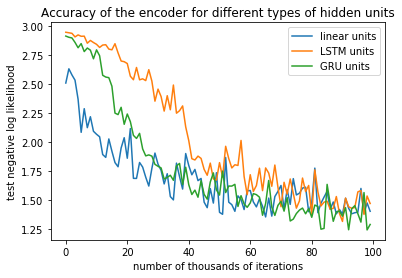

In [0]:
import matplotlib.pyplot as plt

plt.plot(linear_losses, label='linear units')
plt.plot(lstm_losses, label='LSTM units')
plt.plot(gru_losses, label='GRU units')

plt.xlabel('number of thousands of iterations')
plt.ylabel('test negative log likelihood')
plt.title('Accuracy of the encoder for different types of hidden units')
plt.legend()
plt.show()

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




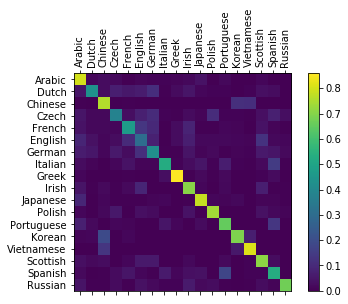

In [0]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [0]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.32) Russian
(-1.90) Czech
(-3.08) Polish

> Jackson
(-0.54) Scottish
(-1.37) English
(-3.08) Russian

> Satoshi
(-0.72) Arabic
(-1.41) Italian
(-1.85) Japanese


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.


